In [1]:
import beautifultools as bt
import pandas as pd
import wordcloud as wc
import pickle
#import qgrid
import os.path

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import nltk
import string
from io import StringIO
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('./data/all-data.csv', header=None, names=['label', 'content'])
df.head()

,label,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df.loc[:, "content"]

0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: content, Length: 4846, dtype: object

In [4]:
df.loc[:, "content"] = df.loc[:, "content"].apply(
    lambda x: " ".join(
        [
            w
            for w in nltk.word_tokenize(x)
            if not w in stopwords.words("English") and len(w) > 2
        ]
    )
)

In [5]:
df.head()

,label,content
0,neutral,According Gran company plans move production R...
1,neutral,Technopolis plans develop stages area less 100...
2,negative,The international electronic industry company ...
3,positive,With new production plant company would increa...
4,positive,According company updated strategy years 2009-...


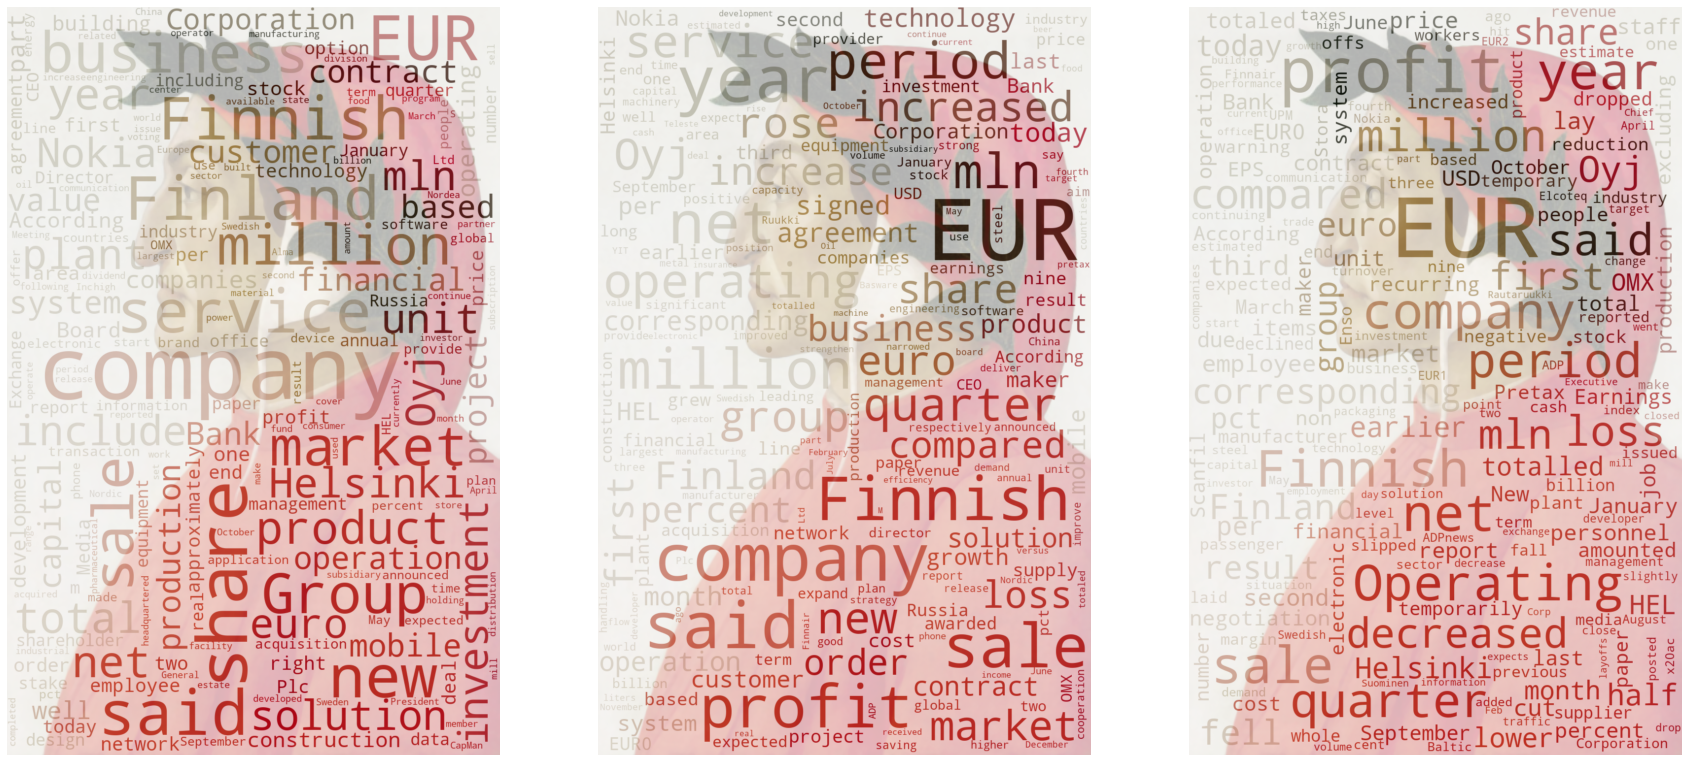

In [6]:
bt.word_cloud([
    " ".join(df[df['label'] == i]['content'].tolist())
    for i in ["neutral", "positive", "negative"]],
    maskPath="img/Portrait_de_Dante.jpg",
    figsize=(30, 20)
)

In [7]:
df["label"] = (df["label"] == "positive").apply(lambda x: float(x))

In [8]:
res = bt.SSESTM(alpha_minus=0.5, alpha_plus=0.5, kappa=3).fit(X=df["content"],
                                                              y=df["label"])

C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jenny\Git\sentiment_modelling\beautifultools.py:596: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tildeD = dS / s[:, None]
C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarni

### Step 1: Feature selection

In [9]:
# Plot results from marginal screening, step 1
res.marginal_screening

,term,score
0,00,0.333333
1,000,0.238372
9,01,0.333333
11,012,0.000000
14,02,0.375000
...,...,...
9873,yit,0.437500
9879,york,0.000000
9880,you,0.000000
9902,zinc,0.857143


### Step 2: Topic modelling

In [10]:
# Creates the topic matrix containing the sentiment information of each sentiment charged word
topicMatrix = pd.DataFrame({
    "S": res.marginal_screening["term"],
    "Op": res.topic_coefficients[:, 0],
    "Om": res.topic_coefficients[:, 1]
})

### Step 3: Scoring on webpage

In [11]:
# Do predict
df["pred"] = res.predict(df["content"])

C:\Users\jenny\Git\sentiment_modelling\beautifultools.py:678: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  D = dS / s[:, None]


## Let's do some real machine learning

In [12]:
# Do train and test split
df_train, df_test = train_test_split(df, test_size=0.07, random_state=1994)

In [13]:
# Check if model exist and load/evaluate it
if os.path.isfile("model/financial_model.pickle"):
    print("Loading model")
    optModel = pickle.load(open("model/financial_model.pickle", 'rb'))

else:
    print("Evaluating model")
    parameters = {
        "kappa": (2, 4, 8, 16),
        "alpha_plus": (0.5, 0.6, 0.7, 0.8),
        "alpha_minus": (0.5, 0.4, 0.3, 0.2),
        "l": (0, 0.2, 0.4, 0.6)
    }

    # Do grid search hyper-parameter tuning with 5-fold cross-validation scoring on MSE
    clf = GridSearchCV(bt.SSESTM(),
                       parameters,
                       n_jobs=3,
                       scoring="neg_mean_squared_error",
                       cv=5,
                       verbose=5)  # Set verbose to maximum

    clf.fit(X=df_train["content"], y=df_train["label"])
    
    # Save this model
    pickle.dump(clf.best_estimator_, open("model/financial_model.pickle", "wb"))
    
    optModel = clf.best_estimator_

Loading model


In [14]:
# look what is inside it
optModel

SSESTM(alpha_minus=0.3, kappa=2, l=0)

In [15]:
# Train model with best parameters
res = optModel.fit(X = df_train["content"], 
                              y = df_train["label"])

# Create an ad-hoc prediction column
df_test = df_test.copy()
df_test["pred"] = res.predict(df_test["content"])

df_test

C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jenny\Git\sentiment_modelling\beautifultools.py:596: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tildeD = dS / s[:, None]
C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarni

,label,content,pred
1356,0.0,The business sales Euro million 44million resp...,0.241191
573,0.0,Under agreement Pfizer funding Biotie research...,0.318489
4399,0.0,Full-year operating result 2008 3.6 million ne...,0.998994
1604,1.0,The aim convert plants flexible manufacturers ...,0.001006
4662,0.0,Cash flow investments amounted EUR45m EUR46m,0.998994
...,...,...,...
1714,0.0,TeliaSonera underlying results however include...,0.536941
3712,0.0,Outotec delivery covers engineering supply con...,0.176156
3906,0.0,The staff reduction start immediately Glaston ...,0.001006
3250,0.0,The Finnish company also reached arrangements ...,0.694552


In [16]:
df_test

,label,content,pred
1356,0.0,The business sales Euro million 44million resp...,0.241191
573,0.0,Under agreement Pfizer funding Biotie research...,0.318489
4399,0.0,Full-year operating result 2008 3.6 million ne...,0.998994
1604,1.0,The aim convert plants flexible manufacturers ...,0.001006
4662,0.0,Cash flow investments amounted EUR45m EUR46m,0.998994
...,...,...,...
1714,0.0,TeliaSonera underlying results however include...,0.536941
3712,0.0,Outotec delivery covers engineering supply con...,0.176156
3906,0.0,The staff reduction start immediately Glaston ...,0.001006
3250,0.0,The Finnish company also reached arrangements ...,0.694552


## Use case Smart Scouting
Use the information contained in the home pages of Siemens customers and potential ones to train an algorithm that outputs a sentiment $p = [0,1]$ on new potential prospects home pages.

In [17]:
import sys

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from scipy.optimize import fminbound

In [18]:
class HiddenPrints:
    """Hide printing from the system.

    It is used only in marginal screening since scipy prints when a
    solution to a linear regression is exactly 0.
    """

    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
def drop_non_sentiment_words(row, sentiment_words, sep=" "):
    """Drop non sentiment charged words in a string. 
    
    The function returns the intersection of row and sentiment words, 
    leaving row with only sentiment charged words. It's possible to 
    provide a separator.
    
    
    Parameters
    ----------
    row : string 
        a string containing words separated by some separator
    
    sentiment_words : list
        a list containing the sentiment charged words
    
    sep : string, default=  ' '
        the separator of words 


    Returns
    -------
    A string with only sentiment charged words separated by sep
    """

    words = row.split(sep)
    return sep.join([i for i in words if i in sentiment_words])

In [19]:
alpha_plus = 0.5
alpha_minus = 0.5
kappa = 1
l = 0.0

X = df_train["content"]
y = df_train["label"]

In [20]:
# MARGINAL SCREENING #
# Init the document term matrix
cvStep1 = CountVectorizer(binary=True)

cvX = cvStep1.fit_transform(X)

# Binarize the order to label whether an observation belongs
# to a client 1 or 0 a prospect
y = y.copy()
ybin = y
ybin[ybin > 0] = 1
ybin[ybin <= 0] = 0

wordfreq = sum(cvX)
wordfreq = wordfreq.toarray()[0, :]

coef = np.array([])

# Suppress print to avoid scipy returning "The exact solution
# is x=0"
with HiddenPrints():

    # Loop for every column in the matrix
    for i in cvX.T:
        coefficient = LinearRegression(fit_intercept=False).fit(i.T, ybin).coef_
        coef = np.concatenate((coef, coefficient))

# Filter the coefficients based on the parameters
coef[(coef < alpha_plus) * (coef > alpha_minus)] = np.nan
coef[wordfreq < kappa] = np.nan

marginal_screening = pd.DataFrame(
    ({"term": cvStep1.get_feature_names(), "score": coef})
).dropna()

C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
marginal_screening

,term,score
0,00,0.333333
1,000,0.234177
2,000063,0.000000
3,002,1.000000
4,0025,0.000000
...,...,...
9517,zip,0.000000
9518,zloty,0.000000
9519,zoltan,0.000000
9520,zone,0.142857


In [22]:
# TOPIC MODELLING #
# Create a column with only sentiment charged keywords
X = X.apply(
    drop_non_sentiment_words,
    sentiment_words = marginal_screening["term"].to_list(),
)

# Remove entries without sentiment charged words
y = y[X != ""]
X = X[X != ""]

# Define p-hat as the normalized rank
y = y.rank(pct=True)

# Initialize weight matrix
W = np.matrix([y, 1 - y]).T

# Compute count of sentiment charged words for each web-page
s = X.apply(lambda row: len(row.split(" ")))

# Create document keyword matrix
cvStep2 = CountVectorizer(vocabulary = marginal_screening["term"].to_list())
dS = cvStep2.fit_transform(X)

# Get sentiment word frequency per document
tildeD = dS / s[:, None]

C:\Users\jenny\AppData\Local\Temp\ipykernel_12908\936450487.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tildeD = dS / s[:, None]


In [23]:
# Fit the linear regression to estimate O matrix
O = LinearRegression(fit_intercept=False).fit(X=W, y=tildeD).coef_

# Set negative coefficients to 0
O[O <= 0] = 0

# Normalize result to l1
normalize(O, norm="l1", axis=0, copy=False, return_norm=False)
topic_coefficients = O

C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\jenny\miniconda3\envs\ml4t\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


## Predict

In [24]:
def mle(x, s, dS, O):
    """ The function implements the log-likelihood of a 
    multinomial with penalty as posed by Kelly et al.


    Parameters
    ----------
    x : float
        the sentiment score

    s : int
        the number of sentiment charged words per web-page

    dS : pandas series
        a series containing sentiment charged words frequencies

    O : array-like
        Matrix containing word positiveness or negativeness.


    Returns
    -------
    v : float
        Return the log-likelihood value given x
    """
    return -(
        (float(s) ** (-1))
        * np.sum(
            np.multiply(
                dS.toarray().T,
                (np.log(0.00000001 + x * O[:, 0] + (1 - x) * O[:, 1]))[:, None],
            )
            + l * np.log(x * (1 - x))
        )
    )

In [25]:
# Create a column with only sentiment charged keywords
X = X.apply(
    drop_non_sentiment_words,
    sentiment_words = marginal_screening["term"].to_list(),
)

# Compute count of sentiment charged words for the web-page
s = X.apply(lambda row: len(row.split(" ")))

# Create document keyword matrix
cvStep3 = CountVectorizer(vocabulary = marginal_screening["term"].to_list())
dS = cvStep3.fit_transform(X)

# Get sentiment word frequency per document
D = dS / s[:, None]

p = []
for i in range(len(s)):
    p.append(
        fminbound(
            mle,
            x1=0.001,
            x2=0.999,
            args=(s.iloc[i], dS[i, :], topic_coefficients),
        )
    )

# Maximize the log-likelihood
y = np.array(p)

C:\Users\jenny\AppData\Local\Temp\ipykernel_12908\3766500287.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  D = dS / s[:, None]
